In [36]:
# Bibliotecas
import sys, pandas as pd, numpy as np
sys.path.append('../')

from env.RiverProblem import RiverProblem
from rl_utils.VizTools import VizTools

# Modelos
from models.ValueIteration import ValueIteration
from models.PolicyIteration import PolicyIteration
from models.RS_PolicyIteration import RS_PolicyIteration
from models.PieceLinear_RSPI import PieceLinear_RSPI

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experimentos - 1S2023

|Data|Descritivo|
|--|--|
|03-2023|Primeiros experimentos com confecção de artigo|

---

## Exponential

2013 MICAI: Shortest Stochastic Path with Risk Sensitive Evaluation \
ou 2016 BRACIS: Extreme Risk Averse Policy for Goal-Directed Risk-Sensitive MDP

## Piecewise Linear

2020 MICAI: Risk-Sensitive Piecewise-Linear Policy Iteration for SSP-MDP

### To-do

**Conjunto de Experimentos + Artigo**

Prazo Rápido

- Medidas de Risco - exponencial e piecewise;
    - (?) quão próximos estão em termos de fator de risco;
    - Um aumento no fator de risco, como influencia em cada medida (?);
    - Curva: K -> Lambda; Lambda -> K;
    - Faz diferença utilizar algum desses métodos (?)
    - Política ótima; performance;...
    - Como Fator de Desconto influencia (?)
    - Adicionar novas medidas + CVAR, por exemplo;
- Descrever formalmente a metodologia/problema;
- Escolher um problema - River Problem - Cachoeira volta ao inicio;
- Escolher vários cenários do Rio, por exemplo, e ver o comportamento da curva gerada.

Implementações: Eduardo, Willy...

In [23]:
def run_river_problem(river_flow, model_obj, epsilon=None, vl_lambda=None, discount_factor=None, 
                                     k=None, gamma=None, alpha=None):
    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)

    is_ok, dict_verification = rp._verify_sum_probabilities(transition_probabilities, block_type)
    if not is_ok: print(f'Soma das Probabilidades está válida? {is_ok}')
    
    if epsilon != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, 
                         num_actions=4, discount_factor=discount_factor, epsilon=epsilon)
    elif vl_lambda != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, vl_lambda,
                         num_actions=4, discount_factor=discount_factor)
    elif k != None and gamma != None and alpha != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, k, alpha, gamma,
                         num_actions=4)
    
    num_iterations = rnp.run_converge()
    hm = viz_tools.visualize_V(rnp, rnp.V, grid_size, 4, goal_state, num_iterations, 
                               str_title=f'RiverProblem w/ ValueIteration - RiverFlow [{river_flow}]')
    
    return rnp

# Value Iteration

In [30]:
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

discount_factor = 0.95
epsilon = 0.001

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

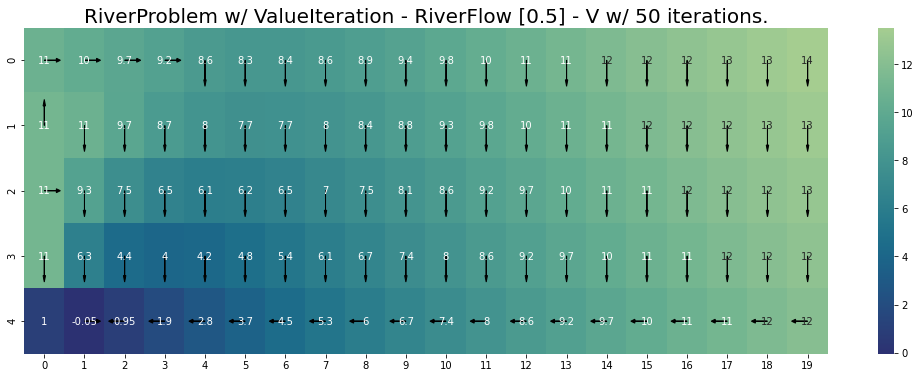

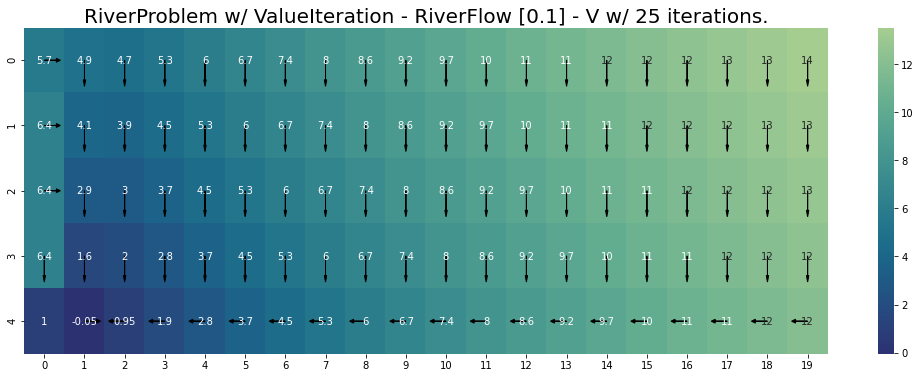

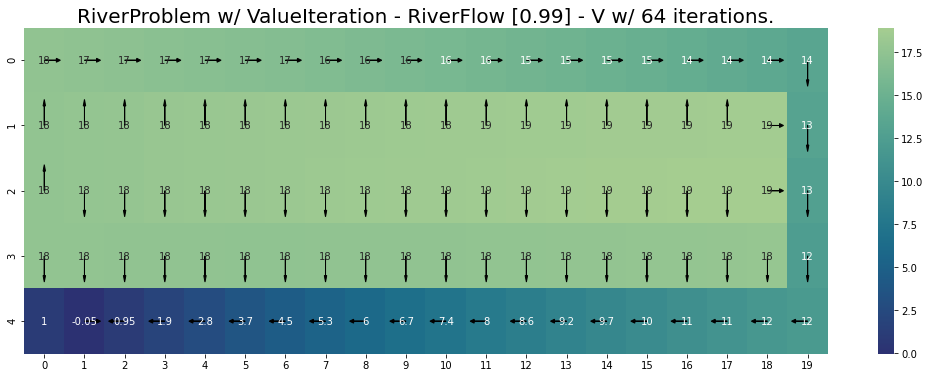

In [31]:
rnp = run_river_problem(river_flow=0.5, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
rnp = run_river_problem(river_flow=0.1, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
rnp = run_river_problem(river_flow=0.99, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)

# Policy Iteration

In [28]:
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

discount_factor = 0.99
epsilon = 0.001

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

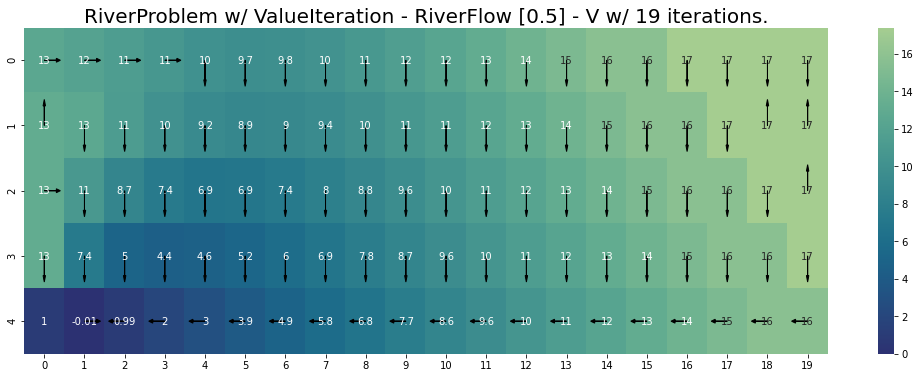

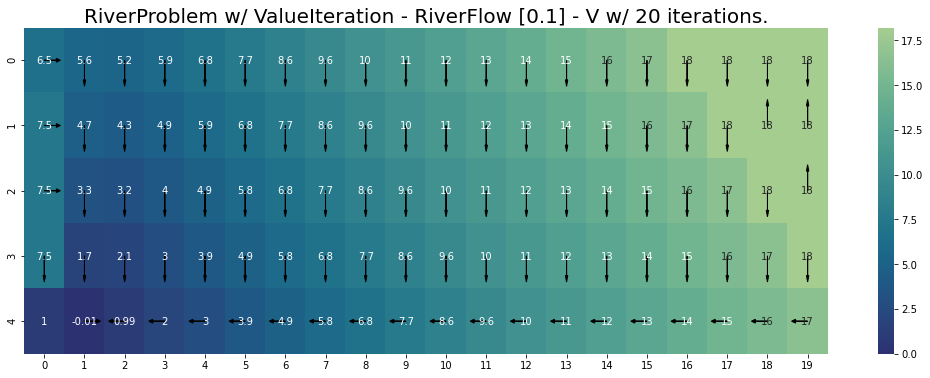

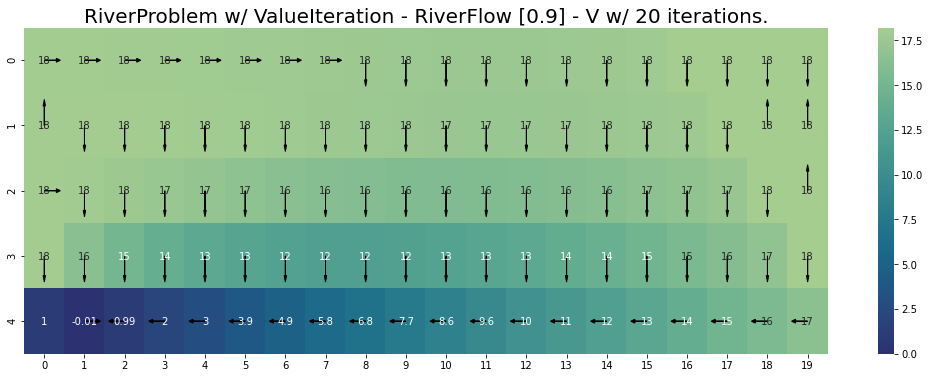

In [29]:
rp_pi = run_river_problem(river_flow=0.5, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
rp_pi = run_river_problem(river_flow=0.1, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
rp_pi = run_river_problem(river_flow=0.9, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)

# RS-MDP

When λ < 0 (risk prone) and the policy π is proper, then π is also λ-feasible. However, this is not guaranteed for all policies when λ > 0 (risk averse). Given a GD-RSMDP, no result exists on how to determine the set of λ > 0 such that exists a λ-feasible policy.

In [32]:
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

discount_factor = 1

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

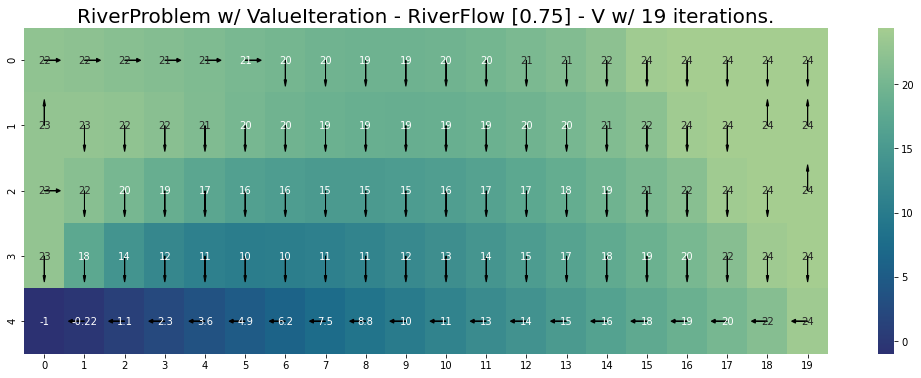

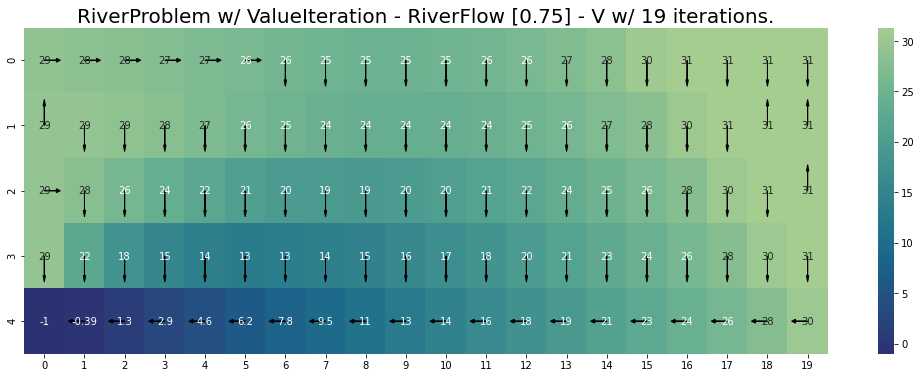

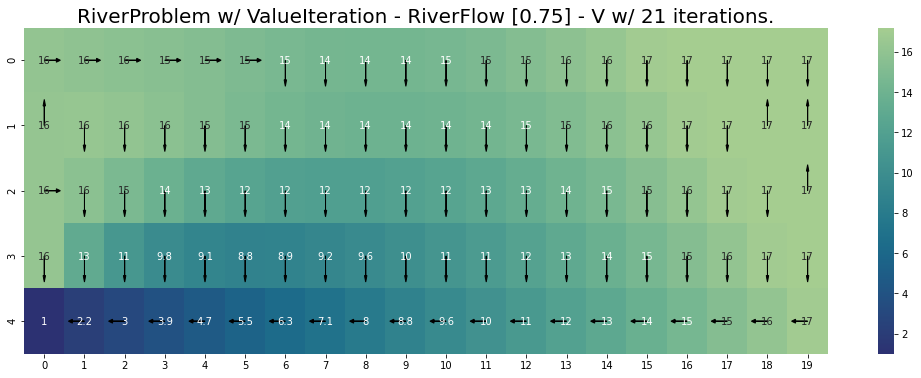

In [33]:
vl_lambda = 0.25
rs_pi = run_risk_sensitive_river_problem(river_flow=0.75, model_obj=RS_PolicyIteration, 
                                         discount_factor=discount_factor, vl_lambda=vl_lambda)

vl_lambda = 0.5
rs_pi = run_risk_sensitive_river_problem(river_flow=0.75, model_obj=RS_PolicyIteration, 
                                         discount_factor=discount_factor, vl_lambda=vl_lambda)

vl_lambda = -0.2
rs_pi = run_risk_sensitive_river_problem(river_flow=0.75, model_obj=RS_PolicyIteration, 
                                         discount_factor=discount_factor, vl_lambda=vl_lambda)

# PieceLinear - RSPI (Risk Sensitive Policy Iteration)

In [37]:
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

gamma = 1
k = -0.9
alpha = 0.95

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

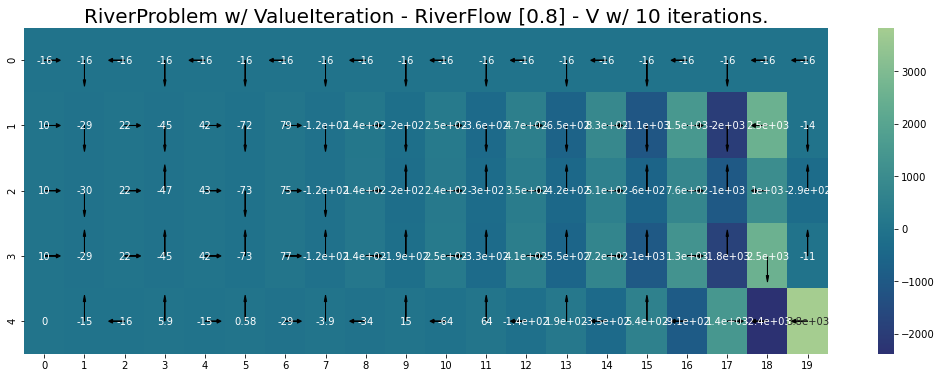

In [66]:
rs_pi = run_risk_sensitive_river_problem(river_flow=0.8, model_obj=PieceLinear_RSPI,
                                        gamma=gamma, k=k, alpha=alpha)